<a href="https://colab.research.google.com/github/SaurabhVaze/airline-delays/blob/main/Project_2_Airline_Delays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier




#Set 1 (Project 2 Dataset)

In [2]:
airlines = pd.read_csv('/content/airdf.csv') #import data

In [3]:
airlines

,Unnamed: 0,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,2,3,AA,2400,LAX,DFW,3,20,165,1
1,3,4,AA,2466,SFO,DFW,3,20,195,1
2,13,14,AA,2408,LAX,DFW,3,55,170,0
3,228,229,AA,2301,ORD,DFW,3,360,150,1
4,230,231,AA,526,SFO,DFW,3,360,215,0
...,...,...,...,...,...,...,...,...,...,...
11019,539271,539272,UA,787,SFO,SAN,5,1357,91,0
11020,539272,539273,UA,455,SFO,LAS,5,1359,94,0
11021,539280,539281,OO,6344,LAX,SAN,5,1360,54,0
11022,539287,539288,UA,927,SFO,LAX,5,1361,88,0


1) Source of data

https://www.kaggle.com/datasets/jimschacko/airlines-dataset-to-predict-a-delay

2) Brief description of data

Dataset of different US flights used to predict whether a flight gets delayed or not.

3) What is the target?

Flight Delayed? (Y/N)

4) Is this a classification or regression problem?

This will be a classification problem 

5) How many features?

7

6) How many rows of data.

11024

7) What, if any, challenges do your foresee in cleaning, exploring, or modeling with this

The lack of numerical features may limit the model's ability to predict accurately, along with a multitude of other factors that play into flight delays, which are not included in this dataset (weather, travel demand, etc.)

#Data Cleaning 

In [4]:
airlines = airlines.drop(['id', 'Flight'], axis = 1) #drop unneeded columns

In [5]:
airlines = airlines.drop(['Unnamed: 0'], axis = 1) #drop unneeded columns

Drop id and Flight number columns, as they provide no benefit in training a model to predict delays

In [6]:
airlines.isna().sum() #check missing values

Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64

**no missing values**

In [7]:
airlines.duplicated().sum()   #check for duplicated rows

4507

**many duplicated rows**

In [8]:
airlines = airlines.drop_duplicates() #drop duplicated rows

In [9]:
airlines.duplicated().sum()   #check for duplicated rows

0

**duplicates removed**

In [10]:
dtypes = airlines.dtypes                           #find any irregularities in the entries within columns of object datatype
strings = dtypes[dtypes == 'object'].index

for c in strings:
  print(f'Column = {c}')
  print(airlines[c].value_counts(dropna = False))
  print('\n\n')

Column = Airline
UA    2327
WN    1272
AA    1256
DL     891
OO     771
Name: Airline, dtype: int64



Column = AirportFrom
LAX    1747
SFO    1369
DEN    1263
ORD    1211
ATL     927
Name: AirportFrom, dtype: int64



Column = AirportTo
LAX    1469
LAS    1338
SFO    1298
DFW    1269
SAN    1143
Name: AirportTo, dtype: int64





**no irregular labels of objects**

In [11]:
airlines.describe()

,DayOfWeek,Time,Length,Delay
count,6517.000000,6517.000000,6517.000000,6517.000000
mean,3.978518,830.233696,151.681602,0.513580
std,1.959339,290.999598,80.971562,0.499854
min,1.000000,20.000000,45.000000,0.000000
25%,2.000000,585.000000,85.000000,0.000000
50%,4.000000,814.000000,145.000000,1.000000
75%,6.000000,1085.000000,202.000000,1.000000
max,7.000000,1369.000000,335.000000,1.000000


**the data seems well distributed but min time of 20 seems unreasonably low**

In [12]:
airlines = airlines[airlines['Time'] != 20] #drop row

drop row that has Time = 20

In [13]:
airlines.describe()

,DayOfWeek,Time,Length,Delay
count,6488.000000,6488.000000,6488.000000,6488.000000
mean,3.977343,833.855271,151.557337,0.513409
std,1.959340,286.550934,81.125010,0.499859
min,1.000000,55.000000,45.000000,0.000000
25%,2.000000,585.000000,85.000000,0.000000
50%,4.000000,820.000000,137.000000,1.000000
75%,6.000000,1085.000000,205.000000,1.000000
max,7.000000,1369.000000,335.000000,1.000000


**55 is also likely too low**

drop row that has Time = 55

In [14]:
airlines = airlines[airlines['Time'] != 55]
airlines.describe()

,DayOfWeek,Time,Length,Delay
count,6473.000000,6473.000000,6473.000000,6473.000000
mean,3.976827,835.660127,151.515372,0.513363
std,1.959042,284.416155,81.214254,0.499860
min,1.000000,353.000000,45.000000,0.000000
25%,2.000000,585.000000,85.000000,0.000000
50%,4.000000,820.000000,135.000000,1.000000
75%,6.000000,1085.000000,205.000000,1.000000
max,7.000000,1369.000000,335.000000,1.000000


**No remaining outliers**

#Exploratory Viz

Text(0.5, 1.0, 'Univariate Distribution of Flight Lengths')

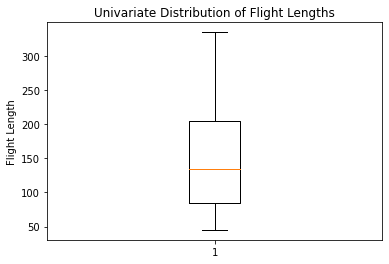

In [15]:
plt.boxplot(x='Length', data = airlines) #univariate boxplot of flight lengths
plt.ylabel('Flight Length')
plt.title('Univariate Distribution of Flight Lengths')


Text(0.5, 1.0, 'Count Distribution of Flight Times')

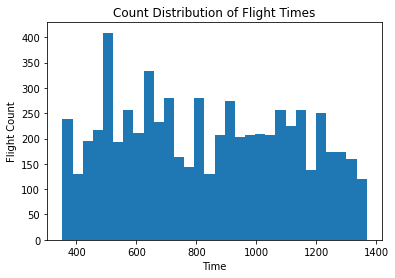

In [16]:
plt.hist('Time', data = airlines, bins = 30) #univariate plot of Time feature
plt.xlabel('Time')
plt.ylabel('Flight Count')
plt.title('Count Distribution of Flight Times')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Flight Count')

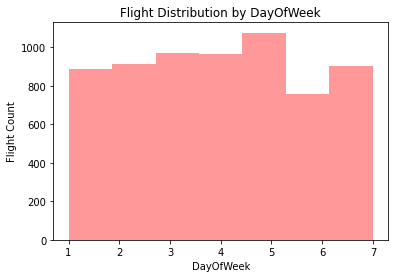

In [17]:
sns.distplot(airlines['DayOfWeek'], bins = 7, kde = False, color = 'red').set(title = 'Flight Distribution by DayOfWeek') #flight DOW distribution
plt.ylabel('Flight Count')

Text(0.5, 1.0, 'Flight On-Time Count')

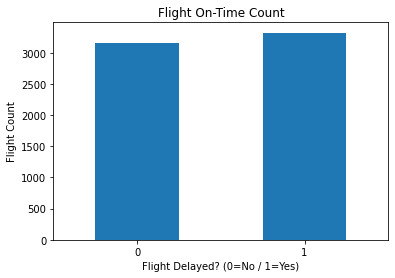

In [18]:
airlines.groupby('Delay').size().plot.bar(rot=0) #target: how many flights were on-time?
plt.xlabel('Flight Delayed? (0=No / 1=Yes)')
plt.ylabel('Flight Count')
plt.title('Flight On-Time Count')

Text(0.5, 1.0, 'Airline Count')

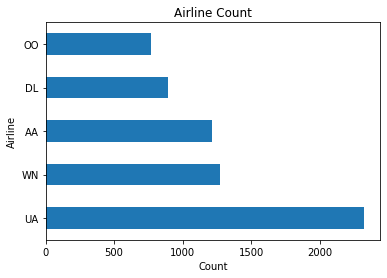

In [19]:
airlines['Airline'].value_counts().plot(kind='barh') #univariate plot of Airline count
plt.xlabel("Count")
plt.ylabel("Airline")
plt.title('Airline Count')

Text(0.5, 1.0, 'Departure Airport Count')

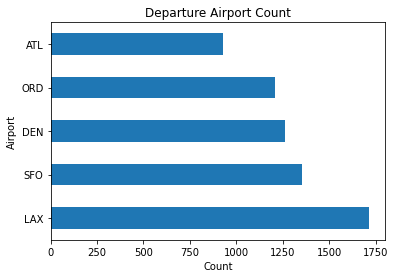

In [20]:
airlines['AirportFrom'].value_counts().plot(kind='barh') #univariate plot of airport count
plt.xlabel("Count")
plt.ylabel("Airport")
plt.title('Departure Airport Count')

Text(0.5, 1.0, 'Arrival Airport Count')

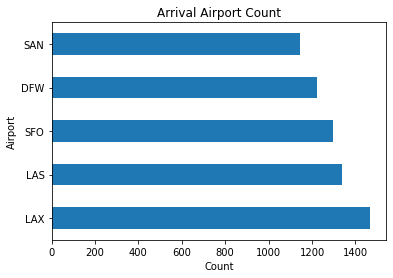

In [21]:
airlines['AirportTo'].value_counts().plot(kind='barh') #univariate plot of airport count
plt.xlabel("Count")
plt.ylabel("Airport")
plt.title('Arrival Airport Count')

#Explanatory Viz

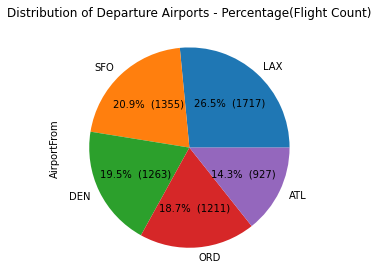

In [22]:
unique, counts = np.unique(airlines['AirportFrom'].value_counts(), return_counts=True) 
unique = np.sort(unique)[::-1]

def make_autopct(unique):       #https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
    def my_autopct(pct):
        total = sum(unique)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

airlines['AirportFrom'].value_counts().plot(kind='pie',autopct=make_autopct(unique)) #pie plot
plt.title('Distribution of Departure Airports - Percentage(Flight Count)') 
plt.tight_layout()


This pie plot shows the distribution of departure airports within this dataset effectively, with LAX representing the largest share of flights, and ATL with the lowest. We can see that the range is approximately 800, with LAX having nearly double the departures compared to ATL within this dataset. DEN and ORD have nearly equal departures, differing by under 60 flights.

Text(0.5, 1.0, 'Length of Delayed/On-Time Flights by Day of Week')

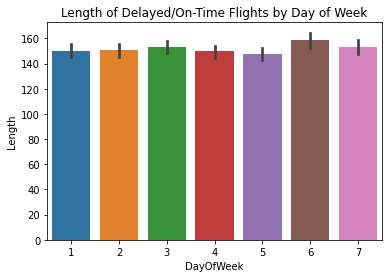

In [23]:
c=sns.barplot(x="DayOfWeek", y="Length", data=airlines) #barplot
plt.title('Length of Delayed/On-Time Flights by Day of Week')


This barplot shows the average flight lengths by Day of the Week, across all departures and arrival airports. We can see that within this dataset,  Saturday seems to have the longest flights followed closely by Sunday and Wednesday. Similarly, the greatest uncertainty in flight length mean is also found on weekends.We can see that the range of the mean lengths is quite homogeneous, with each day's aaverage flight length ~150, with a peak around 160.

#Data Preprocessing

In [24]:
airlines.head()

,Airline,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
3,AA,ORD,DFW,3,360,150,1
4,AA,SFO,DFW,3,360,215,0
5,UA,SFO,LAS,3,360,98,0
6,UA,LAX,SFO,3,360,89,0
7,WN,LAX,SFO,3,360,80,0


In [25]:
X = airlines.drop(columns = 'Delay')

In [26]:
y= airlines['Delay']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42) # Train test split 


In [28]:
#instantiate the selectors to for numeric and categorical data types
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')
#select the numeric columns of each type
num_columns = num_selector(X_train)
cat_columns = cat_selector(X_train)
#check our lists
print('numeric columns are', num_columns)
print('categorical columns are', cat_columns)

numeric columns are ['DayOfWeek', 'Time', 'Length']
categorical columns are ['Airline', 'AirportFrom', 'AirportTo']


In [29]:
mean_imputer = SimpleImputer(strategy='mean')
#Fit the imputer object on the numeric training data with .fit() 
#calculates the medians of the columns in the training set
mean_imputer.fit(X_train[num_columns])
#Use the median from the training data to fill the missing values in 
#the numeric columns of both the training and testing sets with .transform()
X_train.loc[:, num_columns] = mean_imputer.transform(X_train[num_columns])
X_test.loc[:, num_columns] = mean_imputer.transform(X_test[num_columns])
X_train.isna().any() #check for missing


Airline        False
AirportFrom    False
AirportTo      False
DayOfWeek      False
Time           False
Length         False
dtype: bool

In [30]:
#instantiate one hot encoder
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
#fit the OneHotEncoder on the training data
ohe.fit(X_train[cat_columns])
#transform both the training and the testing data
train_ohe = ohe.transform(X_train[cat_columns])
test_ohe = ohe.transform(X_test[cat_columns])
train_ohe

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [31]:
ohe_column_names = ohe.get_feature_names_out(X_train[cat_columns].columns) #get column names
train_ohe = pd.DataFrame(train_ohe, columns=ohe_column_names)
test_ohe = pd.DataFrame(test_ohe, columns=ohe_column_names)
train_ohe

,Airline_AA,Airline_DL,Airline_OO,Airline_UA,Airline_WN,AirportFrom_ATL,AirportFrom_DEN,AirportFrom_LAX,AirportFrom_ORD,AirportFrom_SFO,AirportTo_DFW,AirportTo_LAS,AirportTo_LAX,AirportTo_SAN,AirportTo_SFO
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4849,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4850,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4851,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4852,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [32]:
# instantiate scaler
scaler = StandardScaler()
# fit scaler on training data
scaler.fit(X_train[num_columns])

# transform training data
train_scaled = scaler.transform(X_train[num_columns])
# transform testing data
test_scaled = scaler.transform(X_test[num_columns])

In [33]:
# create a numeric selector
num_selector = make_column_selector(dtype_include='number')
# isolate the numeric columns
train_nums = X_train[num_columns].reset_index(drop=True)
test_nums = X_test[num_columns].reset_index(drop=True)
# re-combine the train and test sets
X_train_processed = pd.concat([train_nums, train_ohe], axis=1)
X_test_processed = pd.concat([test_nums, test_ohe], axis=1)

In [34]:
X_test_processed

,DayOfWeek,Time,Length,Airline_AA,Airline_DL,Airline_OO,Airline_UA,Airline_WN,AirportFrom_ATL,AirportFrom_DEN,AirportFrom_LAX,AirportFrom_ORD,AirportFrom_SFO,AirportTo_DFW,AirportTo_LAS,AirportTo_LAX,AirportTo_SAN,AirportTo_SFO
0,1.0,1215.0,309.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,7.0,960.0,306.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,5.0,1050.0,292.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3.0,1298.0,84.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2.0,732.0,158.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,3.0,885.0,145.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1615,2.0,540.0,190.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1616,3.0,892.0,93.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1617,7.0,695.0,120.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#KNN Model (No PCA)

In [35]:
%%time
# Create and fit the model

knn_pipe = make_pipeline(scaler, KNeighborsClassifier())

knn_pipe.fit(X_train_processed,y_train)

CPU times: user 11 ms, sys: 0 ns, total: 11 ms
Wall time: 14.8 ms


In [36]:
%%time
print('Training accuracy:', knn_pipe.score(X_train_processed, y_train))
print('Testing accuracy:', knn_pipe.score(X_test_processed, y_test))

Training accuracy: 0.669344870210136
Testing accuracy: 0.46201358863495984
CPU times: user 1.11 s, sys: 312 ms, total: 1.42 s
Wall time: 1.86 s


In [37]:
%%time
knn_no_pca = knn_pipe.predict(X_test_processed)

CPU times: user 291 ms, sys: 41.5 ms, total: 332 ms
Wall time: 463 ms


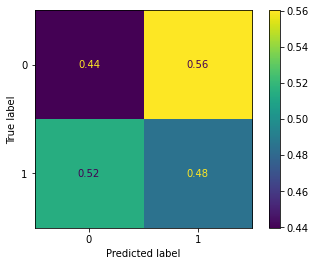

In [38]:

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, knn_no_pca, normalize = 'true')

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_test, knn_no_pca))

              precision    recall  f1-score   support

           0       0.47      0.44      0.45       821
           1       0.46      0.48      0.47       798

    accuracy                           0.46      1619
   macro avg       0.46      0.46      0.46      1619
weighted avg       0.46      0.46      0.46      1619



#Decision Tree Model (No PCA)

In [40]:
dec_tree = DecisionTreeClassifier(random_state = 42) #set same random state

In [41]:
dec_tree.fit(X_train_processed, y_train) #fit model


DecisionTreeClassifier(random_state=42)

In [42]:
train_pred_tree = dec_tree.predict(X_train_processed)
test_pred_tree = dec_tree.predict(X_test_processed)

In [43]:
# evaluate the model
train_score_tree = dec_tree.score(X_train_processed, y_train)
test_score_tree = dec_tree.score(X_test_processed, y_test)
print(train_score_tree)
print(test_score_tree)

0.7748248866913885
0.3292155651636813


In [44]:
dec_tree.get_depth() #get depth of model

29

In [45]:
d = list(range(1,29)) # will try every value between 2 and 29
# Data frame to store the score for each value of max_depth:
scores_tree = pd.DataFrame(index=d, columns=['Test Score','Train Score'])
for depth in d:
    dec_tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_processed, y_train)
    train_score = dec_tree.score(X_test_processed, y_test)
    test_score = dec_tree.score(X_test_processed, y_test)
    scores_tree.loc[depth, 'Train Score'] = train_score
    scores_tree.loc[depth, 'Test Score'] = test_score

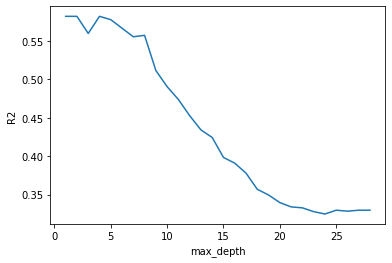

In [46]:
# Visualize which max_depth leads to the highest r2 score
plt.plot(d, scores_tree['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [47]:
depth_4 = DecisionTreeClassifier(max_depth = 4, random_state = 42) #optimized value for max_depth
depth_4.fit(X_train_processed, y_train)
train_4_score = depth_4.score(X_train_processed, y_train)
test_4_score = depth_4.score(X_test_processed, y_test)
print(train_4_score)
print(test_4_score)

0.5900288421920066
0.5818406423718344


In [48]:
%%time
dtree_pred = depth_4.predict(X_test_processed)

CPU times: user 3.13 ms, sys: 0 ns, total: 3.13 ms
Wall time: 5.99 ms


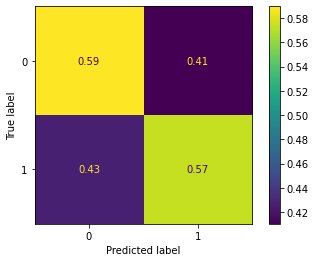

In [49]:

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, dtree_pred, normalize = 'true')

In [50]:
print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

           0       0.59      0.59      0.59       821
           1       0.58      0.57      0.58       798

    accuracy                           0.58      1619
   macro avg       0.58      0.58      0.58      1619
weighted avg       0.58      0.58      0.58      1619



#Bagged Tree Model (No PCA)

In [51]:
bagreg = BaggingClassifier(random_state = 42) #instantiate bagged tree model

In [52]:
bagreg.fit(X_train_processed, y_train)


BaggingClassifier(random_state=42)

In [53]:
bagreg.get_params()

{'base_estimator': None,
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [54]:
bagreg_train_score = bagreg.score(X_train_processed, y_train) #determine untuned accuracy
bagreg_test_score = bagreg.score(X_test_processed, y_test)
print(bagreg_train_score)
print(bagreg_test_score)

0.7678203543469304
0.35453983940704137


In [55]:
param_grid = {'n_estimators': range(1,10),
              'verbose': range(0,1)}
dt_grid_search = GridSearchCV(bagreg, param_grid) #use GridSearchCV to tune hyperparams


In [56]:
dt_grid_search.fit(X_train_processed, y_train)


GridSearchCV(estimator=BaggingClassifier(random_state=42),
             param_grid={'n_estimators': range(1, 10), 'verbose': range(0, 1)})

In [57]:
dt_grid_search.best_params_

{'n_estimators': 1, 'verbose': 0}

In [58]:
#retrieve the best version of the model
best_model = dt_grid_search.best_estimator_
 
#refit the model on the whole training set
best_model.fit(X_train_processed, y_train)
#score the model on the test set
best_model.score(X_test_processed, y_test)

0.410129709697344

In [59]:
bagpred = best_model.predict(X_test_processed)

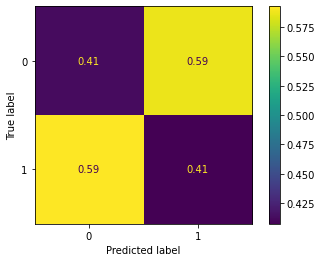

In [60]:
# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, bagpred, normalize = 'true')

In [61]:
print(classification_report(y_test, bagpred))

              precision    recall  f1-score   support

           0       0.42      0.41      0.42       821
           1       0.40      0.41      0.40       798

    accuracy                           0.41      1619
   macro avg       0.41      0.41      0.41      1619
weighted avg       0.41      0.41      0.41      1619



This model is very badly predicting on the test data. The high proportions of false negatives and positives are not helpful in accurate delay predictions.

#**The best performing model on this data was the Decision Tree, and now we can use PCA to try to improve this model's performance and speed.**

The Decision Tree model was the only one of the three tested that returned > .5 testing accuracy score, with the bagged tree performing especially poorly. The speed of the Decision Tree model may also be beneficial if a larger test set is used in the future.

#Decision Tree (With PCA)

In [62]:
# Instantiate, fit & transform data using PCA
pca = PCA(n_components = 0.95)
pca.fit_transform(X_train_processed).shape

(4854, 2)

In [63]:
%%time
# Create and fit the PCA model
dtree_pca_pipe = make_pipeline(scaler, pca, depth_4 )
dtree_pca_pipe.fit(X_train_processed, y_train)

CPU times: user 61.2 ms, sys: 29.5 ms, total: 90.7 ms
Wall time: 105 ms


In [64]:
%%time
print('Training accuracy:', dtree_pca_pipe.score(X_train_processed, y_train))
print('Testing accuracy:', dtree_pca_pipe.score(X_test_processed, y_test))

Training accuracy: 0.5943551709929955
Testing accuracy: 0.5503397158739963
CPU times: user 21.7 ms, sys: 14.3 ms, total: 35.9 ms
Wall time: 93.1 ms


In this case, the introduction of PCA into the Decision Tree pipeline improved neither accuracy on the test set nor did it accelerate the time it took for the model to run. However, of the models tested, the tuned Decision Tree seemed to be the best model in accounting for the greatest amount of variability in the dataset chosen. 


However, with the ultimate goal of this effort being the ability to predict the delay outcome of a specific flight, given the provided features, I cannot say with confidence that this data was the best starting point to develop a truly effective predictive classifier model. The lack of diversity in the values for certain provided features (limited airports, airlines), and missing potential confounding factors (seasonality, time of day, etc.) plays a part in this being a hard dataset to accurately pull conclusions from.
